# Collective, heterogeneous coupling of QuTiP + RT-TDDFT HCN molecules

One important feature of MaxwellLink is its capacity of running collective coupling between many heterogeneous molecular drivers and different EM solvers. In the previous tutorial, we went through the real-time TDDFT calculation of an HCN molecule strongly coupled to the classical cavity mode, with the caveat of using **an unphysically large light-matter coupling strength**.

In this tutorial, we seek to search an efficient way for running collective strong coupling.

## 1. A single TDDFT HCN coupled to a single-mode cavity

Now, let's revisit the coupling of a single-mode cavity to a realistic HCN molecule described by real-time TDDFT.

[Init Molecule] Operating in non-socket mode, using driver: rttddft

  Memory set to   7.451 GiB by Python driver.
  Threads set to 1 by Python driver.
Initial SCF energy: -91.6751251525 Eh
[SingleModeCavity] Completed 1000/10000 [10.0%] steps, time/step: 6.16e-04 seconds, remaining time: 5.54 seconds.
[SingleModeCavity] Completed 2000/10000 [20.0%] steps, time/step: 6.38e-04 seconds, remaining time: 5.02 seconds.
[SingleModeCavity] Completed 3000/10000 [30.0%] steps, time/step: 6.02e-04 seconds, remaining time: 4.33 seconds.
[SingleModeCavity] Completed 4000/10000 [40.0%] steps, time/step: 6.04e-04 seconds, remaining time: 3.69 seconds.
[SingleModeCavity] Completed 5000/10000 [50.0%] steps, time/step: 5.62e-04 seconds, remaining time: 3.02 seconds.
[SingleModeCavity] Completed 6000/10000 [60.0%] steps, time/step: 5.60e-04 seconds, remaining time: 2.39 seconds.
[SingleModeCavity] Completed 7000/10000 [70.0%] steps, time/step: 5.60e-04 seconds, remaining time: 1.77 seconds.
[SingleModeC

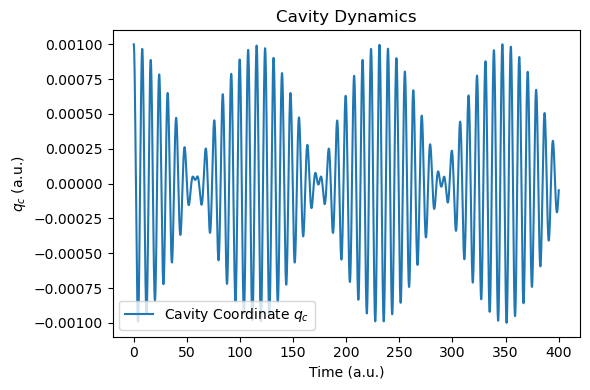

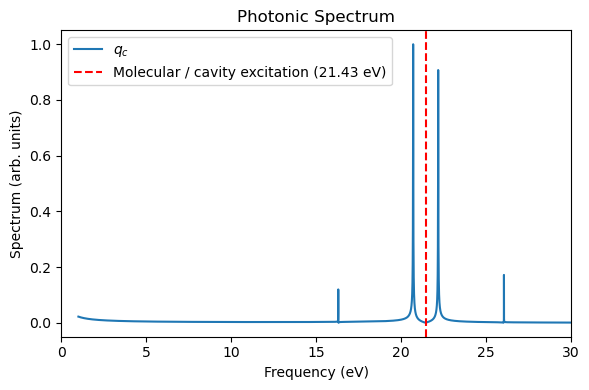

In [1]:
import maxwelllink as mxl
import matplotlib.pyplot as plt
import numpy as np
from maxwelllink.tools import rt_tddft_spectrum

dt_rttddft_au = 0.04  # Time step in atomic units

molecule = mxl.Molecule(
    rescaling_factor=1.0,
    driver="rttddft",
    driver_kwargs={
        "molecule_xyz" : "../tests/data/hcn.xyz",
        "functional" : "scf",
        "basis" : "sto-3g",
        "dt_rttddft_au" : dt_rttddft_au,
        # here we remove the permanent dipole contribution for the connection with QuTiP models 
        # (where permanent dipole is not included)
        "remove_permanent_dipole" : True,
    }
)

sim = mxl.SingleModeSimulation(
    molecules=[molecule],
    frequency_au=0.7876,
    coupling_strength=2e-2,
    damping_au=0.0,
    coupling_axis="z",
    drive=0.0,
    dt_au=dt_rttddft_au,
    qc_initial=[0, 0, 1e-3],
    record_history=True,
    include_dse=True,
)

sim.run(steps=10000)



nskip = 10

def plot_photon_data(sim, t_ref=None, qc_ref=None):
    t = np.array(sim.time_history)
    # qc[-1] is the z-direction cavity coordinate
    qc = np.array([qc[-1] for qc in sim.qc_history])
    dt_au = t[1] - t[0]
    freq_ev, sp, _, _ = rt_tddft_spectrum(qc[::nskip], dt_au=dt_au*nskip, sp_form="absolute", e_start_ev=1.0, e_cutoff_ev=35.0, sigma=1e5, w_step=1e-5)

    if t_ref is not None and qc_ref is not None:
        freq_ev_ref, sp_ref, _, _ = rt_tddft_spectrum(qc_ref[::nskip], dt_au=dt_au*nskip, sp_form="absolute", e_start_ev=1.0, e_cutoff_ev=35.0, sigma=1e5, w_step=1e-5)

    plt.figure(figsize=(6, 4))
    plt.plot(t, qc, label="Cavity Coordinate $q_c$")
    if t_ref is not None and qc_ref is not None:
        plt.plot(t_ref, qc_ref, label="Reference $q_c$", linestyle="--")
    plt.xlabel("Time (a.u.)")
    plt.ylabel("$q_c$ (a.u.)")
    plt.title("Cavity Dynamics")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(freq_ev, sp / np.max(sp), label="$q_c$")
    if t_ref is not None and qc_ref is not None:
        plt.plot(freq_ev_ref, sp_ref / np.max(sp_ref), label="Reference $q_c$", linestyle="--")
    plt.xlabel("Frequency (eV)")
    plt.ylabel("Spectrum (arb. units)")
    plt.xlim(0, 30)
    plt.axvline(21.4311, color="red", linestyle="--", label="Molecular / cavity excitation (21.43 eV)")
    plt.title("Photonic Spectrum")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return t, qc


t_tddft, qc_tddft = plot_photon_data(sim)

## 2. Building QuTiP model Hamiltonian from TDDFT

Because RT-TDDFT calculations can be expensive especially using large basis sets and advanced DFT functionals, we now try to build a model Hamiltonian using QuTiP from linear-response TDDFT calculations.

First, We use linear-response TDDFT to get the excitation energies and transition dipole matrix of the HCN molecule.

In [2]:
model = mxl.RTTDDFTModel(
    molecule_xyz="../tests/data/hcn.xyz",
    functional="scf",
    basis="sto-3g",
)

model.initialize(dt_new=dt_rttddft_au, molecule_id=0)

# calculate LR-TDDFT spectrum
poles, oscillator_strengths, res = model._get_lr_tddft_spectrum(states=28, tda=False, savefile=False)

poles = np.array([r["EXCITATION ENERGY"] for r in res])

tdm_len = np.array(
                [r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"] for r in res]
            )

print("Excitation Energies (a.u.):\n", poles)
print("Transition Dipole Moments (a.u.):\n", tdm_len)

# save energy and transition dipole matrix for QuTiP model
np.savetxt("qutip_input/hcn_tddft_excitation_energies.txt", poles)
np.savetxt("qutip_input/hcn_tddft_transition_dipoles.txt", tdm_len)

Initial SCF energy: -91.6751251525 Eh
Energy (eV): [  7.39216    8.554808   8.554808  10.736077  10.736077  16.312226
  16.66767   16.66767   20.471168  20.471168  21.43112   26.012462
  28.913028  28.913028  33.561233  33.561233  36.688199  38.894917
  45.046956  54.541618 293.643446 293.643446 300.061695 315.270765
 409.606912 409.606912 420.525104 436.943481]
Oscillator strengths: [0.       0.       0.       0.048238 0.048238 0.325466 0.015787 0.015787
 0.321606 0.321606 1.485709 0.395643 0.001497 0.001497 0.001597 0.001597
 0.018092 0.440584 0.000609 0.272348 0.072062 0.072062 0.017407 0.109402
 0.065    0.065    0.04641  0.032024]
Excitation Energies (a.u.):
 [ 0.271657  0.314383  0.314383  0.394543  0.394543  0.599463  0.612525
  0.612525  0.752301  0.752301  0.787579  0.95594   1.062534  1.062534
  1.233352  1.233352  1.348266  1.429361  1.655444  2.004367 10.791193
 10.791193 11.027059 11.585981 15.052769 15.052769 15.454005 16.057369]
Transition Dipole Moments (a.u.):
 [[ 0.  

Then, let's initialize a QuTiP model within MaxwellLink, and try to couple this QuTiP "HCN" molecule to the same cavity with the same initial conditions.

[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[QuTiPModel 0] Warning: No initial state rho0 provided, using ground state.
[SingleModeCavity] Completed 1000/10000 [10.0%] steps, time/step: 3.66e-04 seconds, remaining time: 3.29 seconds.
[SingleModeCavity] Completed 2000/10000 [20.0%] steps, time/step: 3.51e-04 seconds, remaining time: 2.86 seconds.
[SingleModeCavity] Completed 3000/10000 [30.0%] steps, time/step: 4.23e-04 seconds, remaining time: 2.66 seconds.
[SingleModeCavity] Completed 4000/10000 [40.0%] steps, time/step: 3.52e-04 seconds, remaining time: 2.24 seconds.
[SingleModeCavity] Completed 5000/10000 [50.0%] steps, time/step: 3.71e-04 seconds, remaining time: 1.86 seconds.
[SingleModeCavity] Completed 6000/10000 [60.0%] steps, time/step: 3.72e-04 seconds, remaining time: 1.49 seconds.
[SingleModeCavity] Completed 7000/10000 [70.0%] steps, time/step: 3.42e-04 seconds, remaining time

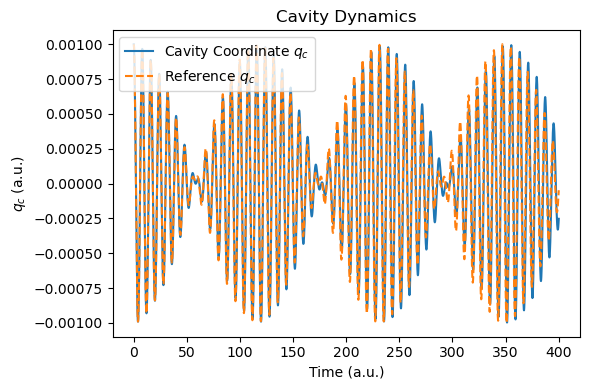

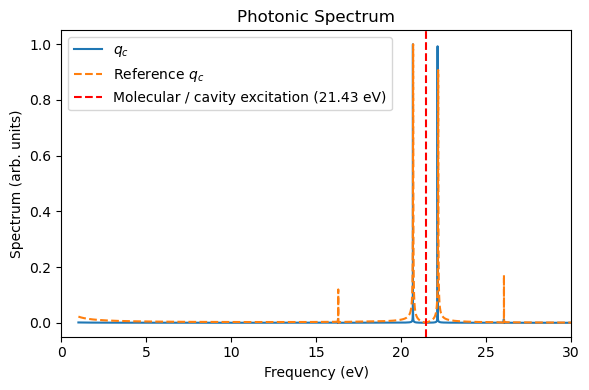

In [3]:
molecule = mxl.Molecule(
    rescaling_factor=1.0,
    driver="qutip",
    driver_kwargs={
        "preset" : "custom",
        "module" : "qutip_input/hcn_qutip.py",
        }
)

sim = mxl.SingleModeSimulation(
    molecules=[molecule],
    frequency_au=0.7876,
    coupling_strength=2e-2,
    damping_au=0.0,
    coupling_axis="z",
    drive=0.0,
    dt_au=dt_rttddft_au,
    qc_initial=[0.0, 0.0, 1e-3],
    record_history=True,
    include_dse=False,
)

sim.run(steps=10000)

_, _, = plot_photon_data(sim, t_ref=t_tddft, qc_ref=qc_tddft)

## 3. Collective strong coupling with QuTiP + RT-TDDFT HCN molecules

The QuTiP "HCN" molecule is largely the same as the direct linear-response TDDFT calculations, except the underestimation of some side peaks. These side peaks should arise from the nonlinear interactions using perturbed electronic densities for propagating the dynamics.

Because the QuTiP "HCN" simulation is more efficient than the direct linear-response TDDFT simulations (especially if a large basis set is used), we can now use many QuTiP "HCN" molecules + one RT-TDDFT HCN molecule to collectively couple to the cavity mode. Such a heterogeneous simulation can be anvantageous if we want a balance between computational cost and accuracy.

Below, we use nine QuTiP "HCN" molecules + one RT-TDDFT HCN molecule as an example ($N=10$). The light-matter coupling per molecule is rescaled with a factor $1/\sqrt{N}$ to ensure the consistent Rabi splitting as the single-molecule strong coupling.

[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[Init Molecule] Operating in non-socket mode, using driver: qutip
[QuTiPModel] Using custom module 'qutip_input/hcn_qutip.py' with params: {}
[Init 

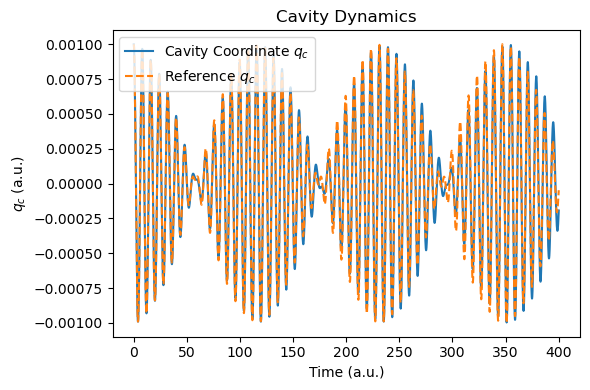

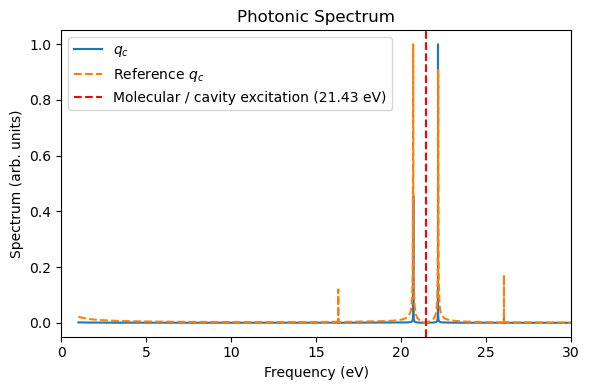

In [4]:
molecules = []

N = 10

# first append N-1 qutip "HCN" molecules
for idx in range(N-1):
    molecule = mxl.Molecule(
        rescaling_factor=1.0,
        driver="qutip",
        driver_kwargs={
            "preset" : "custom",
            "module" : "qutip_input/hcn_qutip.py",
        }
    )
    molecules.append(molecule)

# then append one RTTDDFT HCN molecule
molecule = mxl.Molecule(
    rescaling_factor=1.0,
    driver="rttddft",
    driver_kwargs={
        "molecule_xyz" : "../tests/data/hcn.xyz",
        "functional" : "scf",
        "basis" : "sto-3g",
        "dt_rttddft_au" : dt_rttddft_au,
        "remove_permanent_dipole" : True,
    }
)
molecules.append(molecule)
    

sim = mxl.SingleModeSimulation(
    molecules=molecules,
    frequency_au=0.7876,
    coupling_strength=2e-2/N**0.5,
    damping_au=0.0,
    coupling_axis="z",
    drive=0.0,
    dt_au=dt_rttddft_au,
    qc_initial=[0.0, 0.0, 1e-3],
    record_history=True,
    include_dse=True,
)

sim.run(steps=10000)

_, _, = plot_photon_data(sim, t_ref=t_tddft, qc_ref=qc_tddft)